In [1]:
import math as m
import numpy as np
import scipy as sp

from obspy.core import UTCDateTime, read, Stream, Trace
from obspy.core.inventory.inventory import read_inventory
from obspy.signal.rotate import rotate2zne

import matplotlib.pyplot as plt

We need to define the secant function

In [2]:
def sec(x):
    return 1/m.cos(x)


This is the function that applies the attitude correction (after Lin et al. 2010, BSSA, 
https://doi.org/10.1785/0120090123)<br>
Application of Eqn 10, Eqn 15 and Eqn 4:

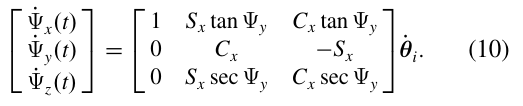 <br>

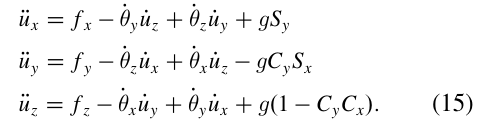 <br>

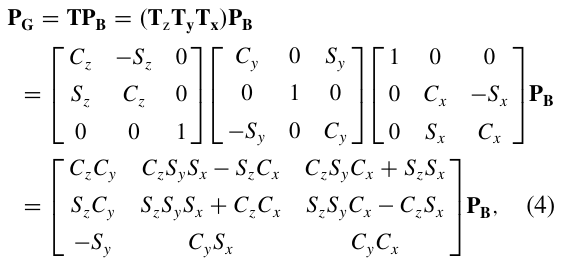



In [3]:
def Attitude(TAxB, TAyB, TAzB, RVxB, RVyB, RVzB, sps, one_g):
####################################################################################################
    
    NN = len(RVxB)				# Length of ORIGINAL data vectors
    dt = 1./sps
  
    if NN != len(RVyB) or NN != len(RVzB) or NN != len(TAxB) or NN != len(TAyB) or NN != len(TAzB):
        print('error: Input vectors must be of equal length!')

    EAx0G = 0
    EAy0G = 0
    EAz0G = 0
     
    ##################################################
    # Pad inputs with a leading zero (length NN+1;
    # thus, ignore first output value) and create
    # output vectors
    
    pTAxB = np.zeros(NN+1)
    pTAxB[1:] = TAxB                    # Input acceleration in {B} ("p" means padded)
    pTAyB = np.zeros(NN+1)
    pTAyB[1:] = TAyB                    # Input acceleration in {B} ("p" means padded)
    pTAzB = np.zeros(NN+1)
    pTAzB[1:] = TAzB                    # Input acceleration in {B} ("p" means padded)
    
    pRVxB = np.zeros(NN+1)
    pRVxB[1:] = RVxB                    # Input rotation rate in {B} ("p" means padded)
    pRVyB = np.zeros(NN+1)
    pRVyB[1:] = RVyB                    # Input rotation rate in {B} ("p" means padded)
    pRVzB = np.zeros(NN+1)
    pRVzB[1:] = RVzB                    # Input rotation rate in {B} ("p" means padded)
    
    pEAxG = np.ones(NN+1)
    pEAxG[0] = EAx0G	# Initialize Euler angles (output; padded)
    pEAyG = np.ones(NN+1)
    pEAyG[0] = EAy0G
    pEAzG = np.ones(NN+1)
    pEAzG[0] = EAz0G
    
    pTVxB = np.zeros(NN+1)	# Starts motionless in {B} (padded)
    pTVyB = np.zeros(NN+1)
    pTVzB = np.zeros(NN+1)
    
    pTVxG = np.ones(NN+1)	# Output velocity in {G} (output; padded)
    pTVyG = np.ones(NN+1)
    pTVzG = np.ones(NN+1)
    
    
    ##################################################
    # Loop over time
    
    for ii in range(NN):
    
    	##########################################
    	# Values used below repeatedly and buffered inputs,
    	# all for time step (ii) and used to generate
    	# outputs at both time steps (ii) and (ii+1)
    
    	SinXg  = m.sin(pEAxG[ii])		# Used repeatedly below
    	CosXg  = m.cos(pEAxG[ii])
    
    	SinYg  = m.sin(pEAyG[ii])		# Ditto ...
    	CosYg  = m.cos(pEAyG[ii])
    	TanYg  = m.tan(pEAyG[ii])
    	SecYg  = sec(pEAyG[ii])
    
    	SinZg  = m.sin(pEAzG[ii])		# Ditto ...
    	CosZg  = m.cos(pEAzG[ii])
    
    	TpRVx  = pRVxB[ii]			# Buffers to avoid overwriting inputs
    	TpRVy  = pRVyB[ii]			#    during computations; also faster
    	TpRVz  = pRVzB[ii]			#    recall ("T" means temporary)
    
    	TpTVxB = pTVxB[ii]			# Ditto ...
    	TpTVyB = pTVyB[ii]
    	TpTVzB = pTVzB[ii]
    
    	TpEAx  = pEAxG[ii]			# Ditto ...
    	TpEAy  = pEAyG[ii]
    	TpEAz  = pEAzG[ii]
    
    
    	##########################################
    	# Step (1)-- Eqn (10) from Lin et al. 20210: ATTITUDE EQUATION; find the
    	# orientation of {B} within {G} (output for time
    	# step (ii+1))
    
    	pEAxG[ii+1] = pEAxG[ii] + (dt * ( TpRVx + (SinXg * TanYg * TpRVy) + (CosXg * TanYg * TpRVz) ))
    
    	pEAyG[ii+1] = pEAyG[ii] + (dt * ((CosXg * TpRVy) - (SinXg * TpRVz) ))
    
    	pEAzG[ii+1] = pEAzG[ii] + (dt * ((SinXg * SecYg * TpRVy) + (CosXg * SecYg * TpRVz) ))
    
    
    	########################################## 
    	# Step (2)-- Eqn (15) from Lin et al. 20210: ATTITUDE-CORRECTION EQUATION -- to
    	# correct the input velocities for tilt (gravity) and
    	# centrifugal forces (output in {B} for time step (ii+1))
    
    	pTVxB[ii+1] = TpTVxB + (dt * ( pTAxB[ii] - (TpRVy * TpTVzB) + (TpRVz * TpTVyB) - (one_g * SinYg) ))
    
    	pTVyB[ii+1] = TpTVyB + (dt * ( pTAyB[ii] - (TpRVz * TpTVxB) + (TpRVx * TpTVzB) + (one_g * CosYg * SinXg) ))
    
    	pTVzB[ii+1] = TpTVzB + (dt * ( pTAzB[ii] - (TpRVx * TpTVyB) + (TpRVy * TpTVxB) + (one_g * (1 - CosYg * CosXg)) ))

    	########################################## 
    	# Step (3)-- Eqn (4) from Lin et al. 20210: TRANSFORM {B} velocities to
    	# {G} velocities (NOTE:  output for time step (ii))
    
    	pTVxG[ii] = TpTVxB * (CosZg * CosYg) + TpTVyB * (CosZg * SinYg * SinXg - SinZg * CosXg) + TpTVzB * (CosZg * SinYg * CosXg + SinZg * SinXg)
    
    	pTVyG[ii] = TpTVxB * (SinZg * CosYg) + TpTVyB * (SinZg * SinYg * SinXg + CosZg * CosXg) + TpTVzB * (SinZg * SinYg * CosXg - CosZg * SinXg)
    
    	pTVzG[ii] = TpTVxB * (-SinYg       ) + TpTVyB * (CosYg * SinXg                        ) + TpTVzB * (CosYg * CosXg                        )

    #########################
    # Since steps (1) and (2) are creating values for
    # time step (ii+1) from values at time step (ii) BUT
    # step (3) is only creating values at time step (ii),
    # so the value of pTV[xyz]B(ii+1) is computed here:
    
    TpTVxB = pTVxB[NN]
    TpTVyB = pTVyB[NN]
    TpTVzB = pTVzB[NN]
    
    SinXg  = m.sin(pEAxG[NN])
    CosXg  = m.cos(pEAxG[NN])
    
    SinYg  = m.sin(pEAyG[NN])
    CosYg  = m.cos(pEAyG[NN])
    
    SinZg  = m.sin(pEAzG[NN])
    CosZg  = m.cos(pEAzG[NN])
    
    pTVxG[NN] = TpTVxB * (CosZg * CosYg) + TpTVyB * (CosZg * SinYg * SinXg - SinZg * CosXg) + TpTVzB * (CosZg * SinYg * CosXg + SinZg * SinXg)
    
    pTVyG[NN] = TpTVxB * (SinZg * CosYg) + TpTVyB * (SinZg * SinYg * SinXg + CosZg * CosXg) + TpTVzB * (SinZg * SinYg * CosXg - CosZg * SinXg)
    
    pTVzG[NN] = TpTVxB * (-SinYg       ) + TpTVyB * (CosYg * SinXg                        ) + TpTVzB * (CosYg * CosXg                        )
    
    
    #########################
    # Reasonably selected records should have zero initial
    # translational velocity, so force this result
    
    tr_pTVxG = Trace(data=pTVxG)
    tr_pTVxG.stats.sampling_rate = sps
    st_ptVxG = Stream(traces=tr_pTVxG)

    tr_pTVyG = Trace(data=pTVyG)
    tr_pTVyG.stats.sampling_rate = sps
    st_ptVyG = Stream(traces=tr_pTVyG)

    tr_pTVzG = Trace(data=pTVzG)
    tr_pTVzG.stats.sampling_rate = sps
    st_ptVzG = Stream(traces=tr_pTVzG)

    
    ##################################################
    # Step (4a), integrate {G} velocities to {G} to
    # displacements (does trivial demean by first sample
    
    
    ##################################################
    # Step (4b), differentiate {G} velocities to {G} accelerations (leading
    # and ending samples of the velocity, pTV[xyz]G, are lost in Deriv3(), so
    # replicate end velocity value on input (the leading velocity input sample
    # being a pad already) and replaces beginning zero on output, the latter
    # just for consistency with other front-padded output arrays)
    
    for tr in st_ptVxG:
        mean = np.mean(tr[:250])
        tr.data = tr.data - mean
    st_ptAxG = st_ptVxG.copy()
    st_ptDxG = st_ptVxG.copy()
    st_ptAxG.differentiate()
    st_ptDxG.integrate()

    for tr in st_ptVyG:
        mean = np.mean(tr[:250])
        tr.data = tr.data - mean
    st_ptAyG = st_ptVyG.copy()
    st_ptDyG = st_ptVyG.copy()
    st_ptAyG.differentiate()
    st_ptDyG.integrate()

    for tr in st_ptVzG:
        mean = np.mean(tr[:250])
        tr.data = tr.data - mean
    st_ptAzG = st_ptVzG.copy()
    st_ptDzG = st_ptVzG.copy()
    st_ptAzG.differentiate()
    st_ptDzG.integrate()

    
    pTAxG = st_ptAxG[0].data
    pTAyG = st_ptAyG[0].data
    pTAzG = st_ptAzG[0].data

    pTVxG = st_ptVxG[0].data
    pTVyG = st_ptVyG[0].data
    pTVzG = st_ptVzG[0].data
    
    pTDxG = st_ptDxG[0].data
    pTDyG = st_ptDyG[0].data
    pTDzG = st_ptDzG[0].data
    
    ##################################################
    # Remove the leading zero pad (the trailing pad
    # for accelerations fell away in Deriv3())
    
    TAxG = pTAxG[1:NN]
    TAyG = pTAyG[1:NN]
    TAzG = pTAzG[1:NN]
    
    TVxG = pTVxG[1:NN]
    TVyG = pTVyG[1:NN]
    TVzG = pTVzG[1:NN]
    
    TDxG = pTDxG[1:NN]
    TDyG = pTDyG[1:NN]
    TDzG = pTDzG[1:NN]
    
    EAxG = pEAxG[1:NN]
    EAyG = pEAyG[1:NN]
    EAzG = pEAzG[1:NN] 

    return (TAxG, TAyG, TAzG, TVxG, TVyG, TVzG, TDxG, TDyG, TDzG, EAxG, EAyG, EAzG)


####################################################################################################



Get the data and pre-process it (remove response, rotate, filter, resample)

3 Trace(s) in Stream:
HV.UWE..HNE | 2018-07-14T05:07:43.000000Z - 2018-07-14T05:08:52.000000Z | 100.0 Hz, 6901 samples
HV.UWE..HNN | 2018-07-14T05:07:43.000000Z - 2018-07-14T05:08:52.000000Z | 100.0 Hz, 6901 samples
HV.UWE..HNZ | 2018-07-14T05:07:43.000000Z - 2018-07-14T05:08:52.000000Z | 100.0 Hz, 6901 samples
3 Trace(s) in Stream:
HV.UWE..HJ1 | 2018-07-14T05:07:43.000100Z - 2018-07-14T05:08:52.000100Z | 200.0 Hz, 13801 samples
HV.UWE..HJ2 | 2018-07-14T05:07:43.000100Z - 2018-07-14T05:08:52.000100Z | 200.0 Hz, 13801 samples
HV.UWE..HJ3 | 2018-07-14T05:07:43.000100Z - 2018-07-14T05:08:52.000100Z | 200.0 Hz, 13801 samples


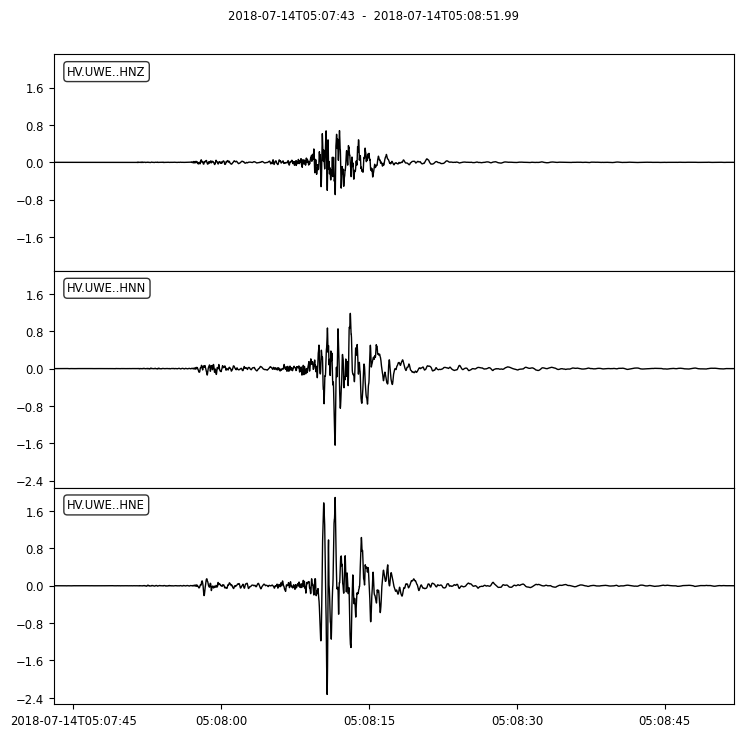

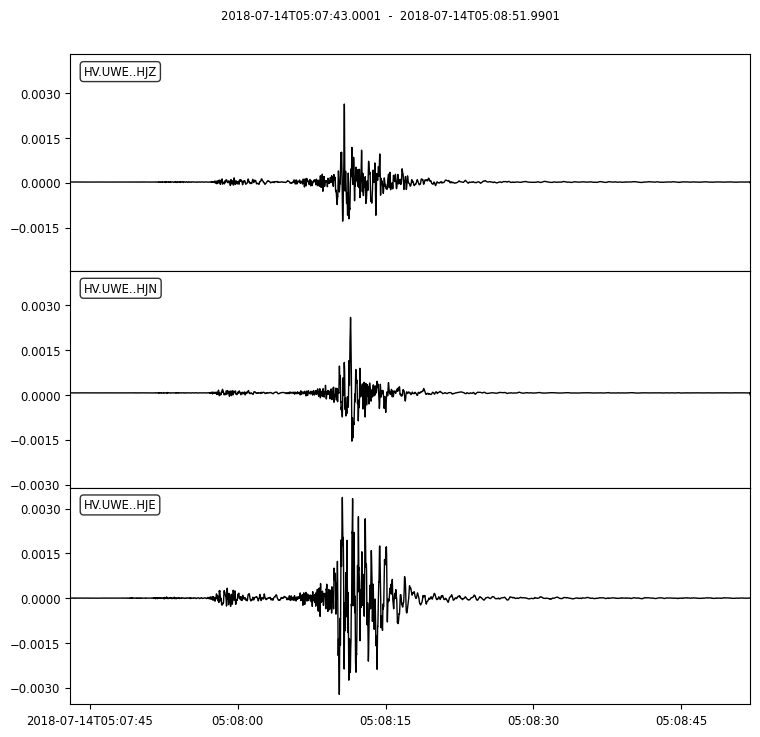

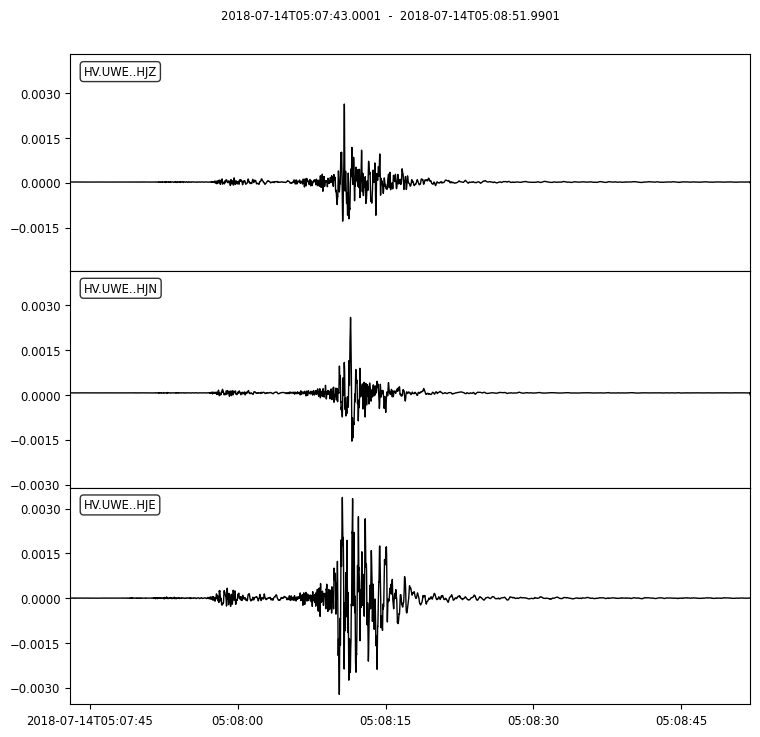

In [4]:
sta = 'UWE'

utctime = UTCDateTime('2018-07-14T05:07:55')

df = 100.0

cha_a = 'HN*'
cha_r = 'HJ*'

path_inv = './'   

#####################
# let's get the data and the meta data
######################    
inv = read_inventory(path_inv+'station_UWE.xml')

# read and pre-process the data

# ACC
st_a = read('UWE_HN.mseed')

st_a.sort()
print(st_a)

st_a.remove_response(inventory=inv, output='ACC')
st_a.rotate(method='->ZNE', inventory=inv, components=["ZNE"])
st_a.filter('lowpass', freq=45.0, corners=8, zerophase=True)
st_a.resample(sampling_rate=df)
for tr in st_a:
    tr.data = tr.data[:-1]

# ROT
st_r = read('UWE_HJ.mseed')
####################

st_r.sort()
print(st_r)

st_r.remove_sensitivity(inventory=inv)
st_r.rotate(method='->ZNE', inventory=inv, components=["123"])
st_r.filter('lowpass', freq=45.0, corners=8, zerophase=True)
st_r.resample(sampling_rate=df)

st_a.plot()
st_r.plot()

Integrate to get velocity, displacement and rotation angle

In [5]:
acc_orig = st_a.copy()
rr_orig = st_r.copy()

####################################################################  
vel_orig = acc_orig.copy()
vel_orig.integrate()

disp_orig = vel_orig.copy()
disp_orig.integrate() # unfiltered displacement from uncorrected acceleration 

ra_orig = rr_orig.copy()
ra_orig.integrate() # unfiltered rotation angle as recorded in the sensor fixed system


3 Trace(s) in Stream:
HV.UWE..HJZ | 2018-07-14T05:07:43.000100Z - 2018-07-14T05:08:51.990100Z | 100.0 Hz, 6900 samples
HV.UWE..HJN | 2018-07-14T05:07:43.000100Z - 2018-07-14T05:08:51.990100Z | 100.0 Hz, 6900 samples
HV.UWE..HJE | 2018-07-14T05:07:43.000100Z - 2018-07-14T05:08:51.990100Z | 100.0 Hz, 6900 samples

In [6]:
sps = st_r[0].stats.sampling_rate
one_g = 9.81

st = st_a + st_r
acc_o = acc_orig.copy()
ra_o = ra_orig.copy()
disp_o = disp_orig.copy()

TAxB = st.select(channel='HNE')[0].data
TAyB = st.select(channel='HNN')[0].data
TAzB = st.select(channel='HNZ')[0].data
RVxB = st.select(channel='HJE')[0].data
RVyB = st.select(channel='HJN')[0].data
RVzB = st.select(channel='HJZ')[0].data

NN   = len(TAxB)

############################
# Remove baselines only from rotation rates

sMnF = 5                        # s at front to fit

nMnF = int(sMnF * sps)

# Compute front means

mnTAfX  = np.mean(TAxB[0:nMnF])             # "f" means "front", i.e., pre-event
mnTAfY  = np.mean(TAyB[0:nMnF])
mnTAfZ  = np.mean(TAzB[0:nMnF])

mnRVfX  = np.mean(RVxB[1:nMnF])             # "f" means "front", i.e., pre-event
mnRVfY  = np.mean(RVyB[1:nMnF])
mnRVfZ  = np.mean(RVzB[1:nMnF])

BlnRVx = mnRVfX;
BlnRVy = mnRVfY;
BlnRVz = mnRVfZ;

RVxB = RVxB - BlnRVx;
RVyB = RVyB - BlnRVy;
RVzB = RVzB - BlnRVz;

In [7]:
###############################################
# here we apply the correction
corr_data = Attitude(TAxB, TAyB, TAzB,
           RVxB, RVyB, RVzB,
           sps, one_g)
################################################

In [8]:
(
TAxGl, TAyGl, TAzGl,
TVxGl, TVyGl, TVzGl,
TDxGl, TDyGl, TDzGl,
EAxGl, EAyGl, EAzGl,
) = corr_data

# define a time axis
sec = np.arange(len(acc_orig[0].data))/(acc_orig[0].stats.sampling_rate)

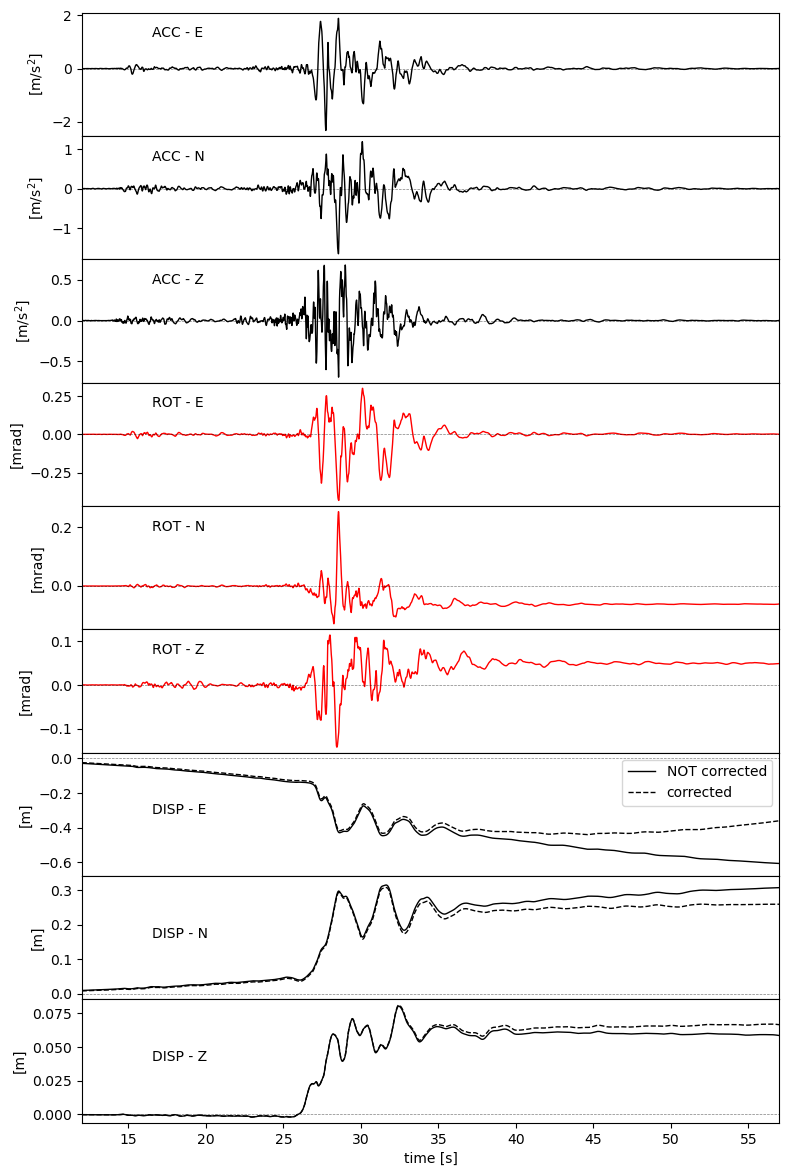

In [9]:
########################################################################
# plot 1 
########################################################################
scale_a = 1
scale_rr = 1e3
scale_d = 1

c_acc = 'k'
c_rr = 'r'
lw_acc = 1
lw_rr = 1
ls_acc = '-'
ls_rr = '-'
ls_acc_c = '--'
ls_rr_c = '--'

duration = 45
dt = 12

fig, ax = plt.subplots(nrows=9, ncols=1, sharex=True, figsize=(9, 12))

line_acc1, = ax[0].plot(sec, acc_o.select(channel='HNE')[0].data*scale_a, color=c_acc, linestyle=ls_acc, linewidth=lw_acc)
line_acc2, = ax[1].plot(sec, acc_o.select(channel='HNN')[0].data*scale_a, color=c_acc, linestyle=ls_acc, linewidth=lw_acc)
line_acc3, = ax[2].plot(sec, acc_o.select(channel='HNZ')[0].data*scale_a, color=c_acc, linestyle=ls_acc, linewidth=lw_acc)

line_ra1_c, = ax[3].plot(sec[:-1], EAxGl*scale_rr, color=c_rr, linestyle=ls_rr, linewidth=lw_rr)
line_ra2_c, = ax[4].plot(sec[:-1], EAyGl*scale_rr, color=c_rr, linestyle=ls_rr, linewidth=lw_rr)
line_ra3_c, = ax[5].plot(sec[:-1], EAzGl*scale_rr, color=c_rr, linestyle=ls_rr, linewidth=lw_rr)

line_disp1, = ax[6].plot(sec, disp_o.select(channel='HNE')[0].data*scale_d, color=c_acc, linestyle=ls_acc, linewidth=lw_acc)
line_disp2, = ax[7].plot(sec, disp_o.select(channel='HNN')[0].data*scale_d, color=c_acc, linestyle=ls_acc, linewidth=lw_acc)
line_disp3, = ax[8].plot(sec, disp_o.select(channel='HNZ')[0].data*scale_d, color=c_acc, linestyle=ls_acc, linewidth=lw_acc)

line_disp1_c, = ax[6].plot(sec[:-1], TDxGl*scale_d, color=c_acc, linestyle=ls_acc_c, linewidth=lw_acc)
line_disp2_c, = ax[7].plot(sec[:-1], TDyGl*scale_d, color=c_acc, linestyle=ls_acc_c, linewidth=lw_acc)
line_disp3_c, = ax[8].plot(sec[:-1], TDzGl*scale_d, color=c_acc, linestyle=ls_acc_c, linewidth=lw_acc)

for _ax in ax:
    _ax.axhline(y=0, color='k', alpha=0.5, linewidth=0.5, linestyle='--')
    _ax.set_xlim(dt, dt+duration)

ax[0].set_ylabel('[m/s$^2$]')
ax[1].set_ylabel('[m/s$^2$]')
ax[2].set_ylabel('[m/s$^2$]')

ax[3].set_ylabel('[mrad]')
ax[4].set_ylabel('[mrad]')
ax[5].set_ylabel('[mrad]')

ax[6].set_ylabel('[m]')
ax[7].set_ylabel('[m]')
ax[8].set_ylabel('[m]')

ax[8].set_xlabel('time [s]')

ax[0].text(0.1, 0.8, 'ACC - E', transform=ax[0].transAxes)
ax[1].text(0.1, 0.8, 'ACC - N', transform=ax[1].transAxes)
ax[2].text(0.1, 0.8, 'ACC - Z', transform=ax[2].transAxes)

ax[3].text(0.1, 0.8, 'ROT - E', transform=ax[3].transAxes)
ax[4].text(0.1, 0.8, 'ROT - N', transform=ax[4].transAxes)
ax[5].text(0.1, 0.8, 'ROT - Z', transform=ax[5].transAxes)

ax[6].text(0.1, 0.5, 'DISP - E', transform=ax[6].transAxes)
ax[7].text(0.1, 0.5, 'DISP - N', transform=ax[7].transAxes)
ax[8].text(0.1, 0.5, 'DISP - Z', transform=ax[8].transAxes)

ax[6].legend((line_disp1, line_disp1_c), ('NOT corrected', 'corrected'))

plt.subplots_adjust(
top=0.99,
bottom=0.065,
left=0.105,
right=0.88,
hspace=0.0
)

plt.show()
